In [196]:
import pandas as pd
import json
import numpy
import csv
import requests
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.stats as linregress
import gmaps
import os

In [197]:
# Import json of list of cities we want to use for group project

my_file = '../Share/city_data.json'
with open(my_file ,'r') as f:
    data = json.loads(f.read())
# Flatten data
cities_df = pd.json_normalize(data)


In [198]:
#Turn data into dataframe grouped by state
cities_df.columns

Index(['datasetid', 'recordid', 'record_timestamp', 'fields.elevation',
       'fields.name', 'fields.modification_date', 'fields.country',
       'fields.feature_class', 'fields.admin3_code', 'fields.alternate_names',
       'fields.feature_code', 'fields.longitude', 'fields.geoname_id',
       'fields.timezone', 'fields.dem', 'fields.country_code',
       'fields.ascii_name', 'fields.latitude', 'fields.admin1_code',
       'fields.coordinates', 'fields.admin2_code', 'fields.population',
       'geometry.type', 'geometry.coordinates'],
      dtype='object')

In [199]:
cities_df = cities_df[['fields.name', 'fields.admin1_code', 'fields.country_code', 'fields.population', 'fields.latitude', 'fields.longitude']]

In [200]:
cities_df = cities_df.rename(columns={'fields.name': 'City', 'fields.admin1_code': 'State', 'fields.country_code': 'Country',
       'fields.population': 'Population', 'fields.latitude': 'Latitude', 'fields.longitude': 'Longitude'})

In [201]:
city_grp = cities_df.groupby(['State'])

In [202]:
#We want to use one city per state, with largest population in each state
lgst_cities = city_grp.apply(lambda g: g[g['Population'] == g['Population'].max()])

In [203]:
lgst_cities = lgst_cities.reset_index(drop=True)
lgst_cities

,City,State,Country,Population,Latitude,Longitude
0,Anchorage,AK,US,298695,61.21806,-149.90028
1,Birmingham,AL,US,212461,33.52066,-86.80249
2,Little Rock,AR,US,197992,34.74648,-92.28959
3,Phoenix,AZ,US,1563025,33.44838,-112.07404
4,Los Angeles,CA,US,3971883,34.05223,-118.24368
5,Denver,CO,US,682545,39.73915,-104.9847
6,Bridgeport,CT,US,147629,41.17923,-73.18945
7,Washington,DC,US,601723,38.89511,-77.03637
8,Wilmington,DE,US,71948,39.74595,-75.54659
9,Jacksonville,FL,US,868031,30.33218,-81.65565


In [204]:
#Create collumns for our new data from our API showing quality of life ratings for the cities we pre-selected
new_cols = ['Housing', 'Cost of Living', 'Startups', 'Venture Capital', 'Travel Connectivity', 'Commute', 'Business Freedom', 'Safety', 'Healthcare', 'Education', 'Environmental Quality', 'Economy', 'Taxation', 'Internet Access', 'Leisure & Culture']
for col in new_cols:
    lgst_cities[col] = ""
lgst_cities

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Startups,Venture Capital,...,Commute,Business Freedom,Safety,Healthcare,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture
0,Anchorage,AK,US,298695,61.21806,-149.90028,,,,,...,,,,,,,,,,
1,Birmingham,AL,US,212461,33.52066,-86.80249,,,,,...,,,,,,,,,,
2,Little Rock,AR,US,197992,34.74648,-92.28959,,,,,...,,,,,,,,,,
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,,,,,...,,,,,,,,,,
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,,,,,...,,,,,,,,,,
5,Denver,CO,US,682545,39.73915,-104.9847,,,,,...,,,,,,,,,,
6,Bridgeport,CT,US,147629,41.17923,-73.18945,,,,,...,,,,,,,,,,
7,Washington,DC,US,601723,38.89511,-77.03637,,,,,...,,,,,,,,,,
8,Wilmington,DE,US,71948,39.74595,-75.54659,,,,,...,,,,,,,,,,
9,Jacksonville,FL,US,868031,30.33218,-81.65565,,,,,...,,,,,,,,,,


In [205]:
#MAKE REQUEST AND STORE DATA BACK IN DATAFRAME

#The URL will only let you find the city in an urban area and then push the
#urban area into the query - it's nested.  They provide some instructions, 
#but their example is wrong, so don't follow that.  The instructions are:  
#"Alternatively, we can find the Urban Area that a city belongs to. E.g. let
#'s find out how the urban area corresponding to Palo Alto, 
#California performs in terms of Teleport scores. 
#Let's use the API Explorer for the city search endpoint to construct the 
#URL. In the search field enter Palo Alto, California, in the embed field, 
#type city:search-results/city:item/city:urban_area/ua:scores, and click 
#the Try it out! button."

#Base URL 
url_open = 'https://api.teleport.org/api/cities/?search='
url_close = "&limit=1&embed=city%3Asearch-results%2Fcity%3Aitem%2Fcity%3Aurban_area%2Fua%3Ascores"

#create a list to loop to gather json data from response
my_categories = pd.DataFrame(new_cols)

print("""
Beginning processing city data:
------------------------------------------""")

#loop dataframe randomly created above and return quality of life data / 
#use the index so the return data can be pushed into the existing 
#lgst_cities dataframe

for ind in lgst_cities.index:

    #get city data and transform 
    my_city = lgst_cities['City'][ind].replace(' ', '%20')
    my_state = lgst_cities['State'][ind]

    urban_area = my_city + '%2C%20' + my_state

    # Build query URL
    query_url = f"{url_open}{urban_area}{url_close}"

    #make request and hold response
    response = requests.get(query_url).json()
    
    try:
        print(f"Processing Record {ind + 1} of {len(lgst_cities)}: {my_city}, {my_state}.")
        
        #gather data for each category
        for x in my_categories.index:
                    
            my_category = my_categories.iloc[x, 0]
                    
            #parse json for data
            my_data = response['_embedded']['city:search-results'][0]['_embedded']['city:item']['_embedded']['city:urban_area']['_embedded']['ua:scores']['categories'][x]['score_out_of_10']
                    
            #write the data to the dataframe
            lgst_cities.loc[lgst_cities.index[ind], my_category] = my_data

    except (KeyError, IndexError):
        print("Missing field/result... skipping.")



Beginning processing city data:
------------------------------------------
Processing Record 1 of 51: Anchorage, AK.
Processing Record 2 of 51: Birmingham, AL.
Processing Record 3 of 51: Little%20Rock, AR.
Missing field/result... skipping.
Processing Record 4 of 51: Phoenix, AZ.
Processing Record 5 of 51: Los%20Angeles, CA.
Processing Record 6 of 51: Denver, CO.
Processing Record 7 of 51: Bridgeport, CT.
Missing field/result... skipping.
Processing Record 8 of 51: Washington, DC.
Processing Record 9 of 51: Wilmington, DE.
Missing field/result... skipping.
Processing Record 10 of 51: Jacksonville, FL.
Processing Record 11 of 51: Atlanta, GA.
Processing Record 12 of 51: Honolulu, HI.
Processing Record 13 of 51: Des%20Moines, IA.
Processing Record 14 of 51: Boise, ID.
Processing Record 15 of 51: Chicago, IL.
Processing Record 16 of 51: Indianapolis, IN.
Processing Record 17 of 51: Wichita, KS.
Missing field/result... skipping.
Processing Record 18 of 51: Lexington-Fayette, KY.
Missing fi

In [206]:
lgst_cities

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Startups,Venture Capital,...,Commute,Business Freedom,Safety,Healthcare,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,2.7945,0,...,4.71525,8.671,3.4705,8.63267,3.6245,9.272,6.5145,4.772,4.9645,3.266
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,4.3575,1,...,2.02075,8.671,1.776,8.74333,3.6245,7.0375,6.5145,4.204,5.1605,5.3835
2,Little Rock,AR,US,197992,34.74648,-92.28959,,,,,...,,,,,,,,,,
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.533,6.208,6.5085,4.558,...,4.8285,8.671,2.583,8.56733,4.591,4.62525,6.5145,4.488,6.178,6.81
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,10,10,...,3.677,8.57467,5.705,8.43967,8.6245,4.7315,6.5145,4.7675,5.4965,9.196
5,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,7.8645,6.117,...,4.53,8.671,5.371,8.61567,3.6245,7.11675,6.5145,4.346,5.4185,6.2235
6,Bridgeport,CT,US,147629,41.17923,-73.18945,,,,,...,,,,,,,,,,
7,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,8.774,8.056,...,4.457,8.671,2.1915,8.49067,5.9685,6.99375,6.5145,4.062,3.8255,10
8,Wilmington,DE,US,71948,39.74595,-75.54659,,,,,...,,,,,,,,,,
9,Jacksonville,FL,US,868031,30.33218,-81.65565,6.45,5.359,4.3475,2.545,...,1.40575,8.671,3.8255,8.498,3.6245,7.12025,6.5145,4.772,6.1575,5.6545


In [207]:
#Drop the data that will notbe reviewed in this code
qol_df= lgst_cities.drop(['Startups','Venture Capital','Business Freedom','Safety','Healthcare','Environmental Quality','Economy','Taxation','Internet Access','Leisure & Culture'], axis=1)
qol_df

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.738,4.71525,3.6245
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
2,Little Rock,AR,US,197992,34.74648,-92.28959,,,,,
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.533,6.208,3.3025,4.8285,4.591
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.677,8.6245
5,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.243,4.53,3.6245
6,Bridgeport,CT,US,147629,41.17923,-73.18945,,,,,
7,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.505,4.457,5.9685
8,Wilmington,DE,US,71948,39.74595,-75.54659,,,,,
9,Jacksonville,FL,US,868031,30.33218,-81.65565,6.45,5.359,1.5675,1.40575,3.6245


In [208]:
#Clean the missing data

nan_value = float("NaN")
qol_df.replace("", nan_value, inplace=True)

qol_df.dropna(inplace=True)

qol_df

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.67700,8.6245
5,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.2430,4.53000,3.6245
7,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.5050,4.45700,5.9685
9,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245
10,Atlanta,GA,US,463878,33.749,-84.38798,4.9755,5.241,5.2915,3.89775,6.4570
11,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805
12,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245


In [209]:
qol_df=qol_df.reset_index()
qol_df.head(3)

,index,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245
1,1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
2,3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910


In [210]:
qol_df=qol_df.drop(columns=['index'])
qol_df
qol_df.to_csv("CityScoresOriginal.csv")

In [211]:
qol_df.describe()

,Population,Housing,Cost of Living,Travel Connectivity,Commute,Education
count,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000
mean,9.847224e+05,4.785542,4.776389,2.922931,3.967465,4.970806
std,1.458472e+06,2.190898,1.618827,1.527034,1.306818,1.602809
min,6.688100e+04,0.000000,0.000000,1.102000,0.933000,3.624500
25%,3.851270e+05,3.564750,4.381250,1.643000,3.363250,3.624500
50%,6.227980e+05,5.386250,5.117500,2.810750,4.526875,4.248000
75%,8.277522e+05,6.538625,5.881500,3.669625,4.909750,5.834000
max,8.175133e+06,7.262000,6.578000,6.675000,5.519250,8.624500


In [212]:
cities= qol_df['City']
housing= qol_df['Housing'].astype('float')
living= qol_df['Cost of Living'].astype('float')
travel= qol_df['Travel Connectivity'].astype('float')
commute= qol_df['Commute'].astype('float')
education= qol_df['Education'].astype('float')
pop= qol_df['Population'].astype('float')
lat= qol_df['Latitude'].astype('float')
lon= qol_df['Longitude'].astype('float')
state= qol_df['State']

In [213]:

# Create a map usingcoordinates to set markers
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = housing,
                                 dissipating=False, max_intensity=np.max(housing), 
                                point_radius=2.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [214]:

# Create a map usingcoordinates to set markers
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = living,
                                 dissipating=False, max_intensity=np.max(living), 
                                point_radius=2.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [215]:
# Create a map usingcoordinates to set markers
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = travel,
                                 dissipating=False, max_intensity=np.max(travel), 
                                point_radius=2.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [216]:
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = commute,
                                 dissipating=False, max_intensity=np.max(commute), 
                                point_radius=2.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [217]:
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = education,
                                 dissipating=False, max_intensity=np.max(education), 
                                point_radius=2.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [218]:
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = pop,
                                 dissipating=False, max_intensity=np.max(pop), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [219]:
info_box_template = """
<dl>
<dt>Name</dt><dd>{State Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
locations = qol_df[["Latitude", "Longitude"]].astype(float)

markers = gmaps.marker_layer(locations, info_box_content=cities)
fig.add_layer(markers)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

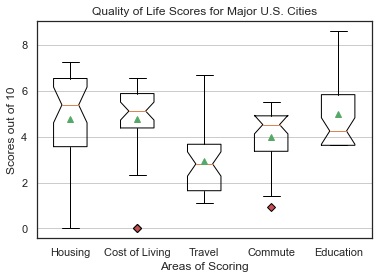

In [220]:
labels = ['Housing', 'Cost of Living', 'Travel', 'Commute',
          'Education']

areas= [housing, living, travel, commute, education]

fig, ax1 = plt.subplots()

diamond = dict(markerfacecolor='r', marker='D')

ax1.set_title('Quality of Life Scores for Major U.S. Cities')
ax1.yaxis.grid(True)
ax1.set_xlabel('Areas of Scoring')
ax1.set_ylabel('Scores out of 10')

ax1.boxplot(areas, labels=labels, notch=True, flierprops=diamond, showmeans=True)

plt.savefig("BoxPlot.png")
plt.show()

In [221]:
# Perform the ANOVA
stats.f_oneway(housing, living, travel, commute, education)

F_onewayResult(statistic=9.361008326196853, pvalue=7.036607698384077e-07)

In [222]:
# If the data is in a dataframe, we use pandas to give quartile calculations
hquartiles = housing.quantile([.25,.5,.75])
hlowerq = hquartiles[0.25]
hupperq = hquartiles[0.75]
hiqr = hupperq-hlowerq

print(f"The lower quartile of housing is: {hlowerq}")
print(f"The upper quartile of housing is: {hupperq}")
print(f"The interquartile range of housing is: {hiqr}")
print(f"The the median of housing is: {hquartiles[0.5]} ")

hlower_bound = hlowerq - (1.5*hiqr)
hupper_bound = hupperq + (1.5*hiqr)
print(f"Values below {hlower_bound} could be outliers.")
print(f"Values above {hupper_bound} could be outliers.")

The lower quartile of housing is: 3.5647500000000005
The upper quartile of housing is: 6.538625
The interquartile range of housing is: 2.973874999999999
The the median of housing is: 5.38625 
Values below -0.896062499999998 could be outliers.
Values above 10.999437499999999 could be outliers.


In [223]:
lquartiles = living.quantile([.25,.5,.75])
llowerq = lquartiles[0.25]
lupperq = lquartiles[0.75]
liqr = lupperq-llowerq

print(f"The lower quartile of cost of living is: {llowerq}")
print(f"The upper quartile of cost of living is: {lupperq}")
print(f"The interquartile range of cost of living is: {liqr}")
print(f"The the median of cost of living is: {hquartiles[0.5]} ")

llower_bound = llowerq - (1.5*liqr)
lupper_bound = lupperq + (1.5*liqr)
print(f"Values below {llower_bound} could be outliers.")
print(f"Values above {lupper_bound} could be outliers.")

The lower quartile of cost of living is: 4.3812500000000005
The upper quartile of cost of living is: 5.8815
The interquartile range of cost of living is: 1.5002499999999994
The the median of cost of living is: 5.38625 
Values below 2.1308750000000014 could be outliers.
Values above 8.131874999999999 could be outliers.


In [224]:
tquartiles = travel.quantile([.25,.5,.75])
tlowerq = tquartiles[0.25]
tupperq = hquartiles[0.75]
tiqr = tupperq-tlowerq

print(f"The lower quartile of travel connectivity is: {tlowerq}")
print(f"The upper quartile of travel connectivity is: {tupperq}")
print(f"The interquartile range of travel connectivity is: {tiqr}")
print(f"The the median of travel connectivity is: {tquartiles[0.5]} ")

tlower_bound = tlowerq - (1.5*tiqr)
tupper_bound = tupperq + (1.5*tiqr)
print(f"Values below {tlower_bound} could be outliers.")
print(f"Values above {tupper_bound} could be outliers.")

The lower quartile of travel connectivity is: 1.6430000000000002
The upper quartile of travel connectivity is: 6.538625
The interquartile range of travel connectivity is: 4.895624999999999
The the median of travel connectivity is: 2.8107499999999996 
Values below -5.700437499999998 could be outliers.
Values above 13.882062499999998 could be outliers.


In [225]:
cquartiles = commute.quantile([.25,.5,.75])
clowerq = cquartiles[0.25]
cupperq = cquartiles[0.75]
ciqr = cupperq-clowerq

print(f"The lower quartile of commute is: {clowerq}")
print(f"The upper quartile of commute is: {cupperq}")
print(f"The interquartile range of commute is: {ciqr}")
print(f"The the median of commute is: {cquartiles[0.5]} ")

clower_bound = clowerq - (1.5*ciqr)
cupper_bound = cupperq + (1.5*ciqr)
print(f"Values below {clower_bound} could be outliers.")
print(f"Values above {cupper_bound} could be outliers.")

The lower quartile of commute is: 3.3632500000000007
The upper quartile of commute is: 4.90975
The interquartile range of commute is: 1.546499999999999
The the median of commute is: 4.526875 
Values below 1.043500000000002 could be outliers.
Values above 7.229499999999998 could be outliers.


In [226]:
equartiles = education.quantile([.25,.5,.75])
elowerq = equartiles[0.25]
eupperq = equartiles[0.75]
eiqr = eupperq-elowerq

print(f"The lower quartile of housing is: {elowerq}")
print(f"The upper quartile of housing is: {eupperq}")
print(f"The interquartile range of housing is: {eiqr}")
print(f"The the median of housing is: {equartiles[0.5]} ")

elower_bound = elowerq - (1.5*eiqr)
eupper_bound = eupperq + (1.5*eiqr)
print(f"Values below {elower_bound} could be outliers.")
print(f"Values above {eupper_bound} could be outliers.")

The lower quartile of housing is: 3.6245
The upper quartile of housing is: 5.834
The interquartile range of housing is: 2.2095
The the median of housing is: 4.247999999999999 
Values below 0.31025000000000036 could be outliers.
Values above 9.148249999999999 could be outliers.


R squared: 0.011315613918332948


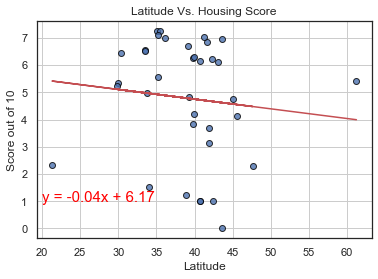

In [227]:
from scipy.stats import linregress
import seaborn as sns

#Store as x and y values
x_values = lat
y_values = housing

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Housing Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsHousing.png")

# Show plot
plt.show()

R squared: 0.04349257799224935


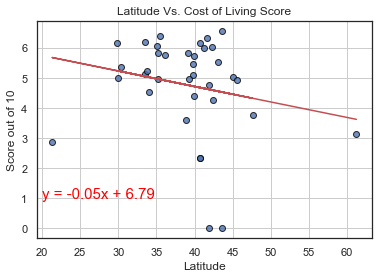

In [228]:
#Store as x and y values
x_values = lat
y_values = living

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Cost of Living Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsLiving.png")

# Show plot
plt.show()

R squared: 0.00043810006006456196


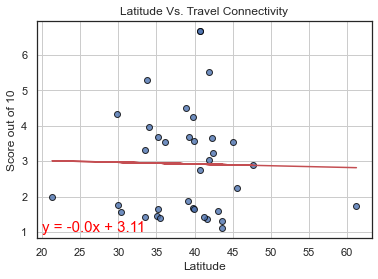

In [229]:
#Store as x and y values
x_values = lat
y_values = travel

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Travel Connectivity')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsTravel.png")

# Show plot
plt.show()

R squared: 0.016728887798291212


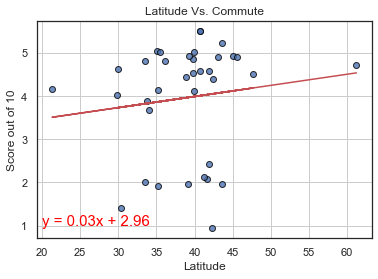

In [230]:
#Store as x and y values
x_values = lat
y_values = commute

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Commute')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsCommute.png")

# Show plot
plt.show()

R squared: 0.006204019891388824


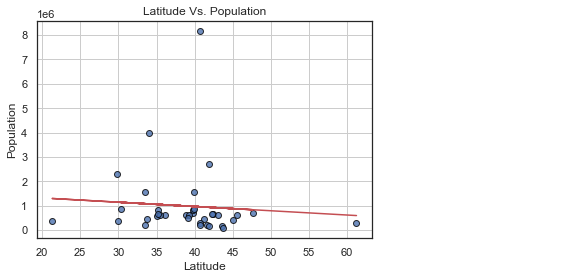

In [231]:
#Store as x and y values
x_values = lat
y_values = pop

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(65,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Population')
plt.title('Latitude Vs. Population')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsPopulation.png")

# Show plot
plt.show()

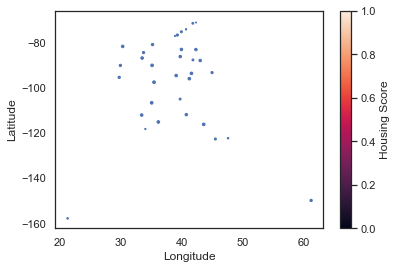

In [232]:
# Bonus - plot the latitude and longitude of the California housing data using Matplotlib, color the data points using the median income of the block.
plt.scatter(lat,lon,housing)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Housing Score")

plt.savefig("Housingscores.png")
plt.show()

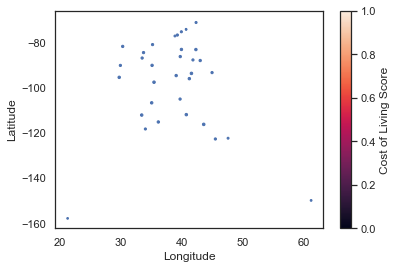

In [233]:
plt.scatter(lat,lon,living)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Cost of Living Score")
plt.savefig("costscore.png")
plt.show()

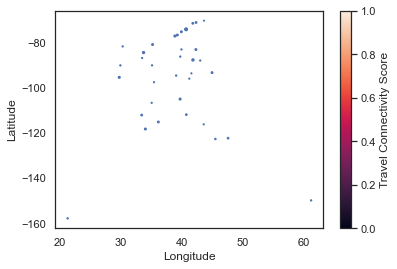

In [234]:
plt.scatter(lat,lon,travel)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Travel Connectivity Score")
plt.savefig("travelscores.png")
plt.show()

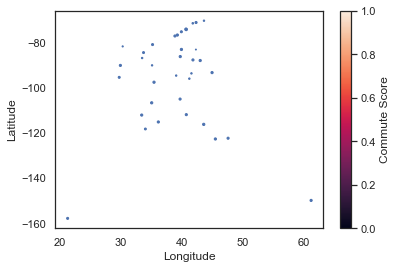

In [235]:
plt.scatter(lat,lon,commute)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Commute Score")
plt.savefig("commutescore.png")
plt.show()

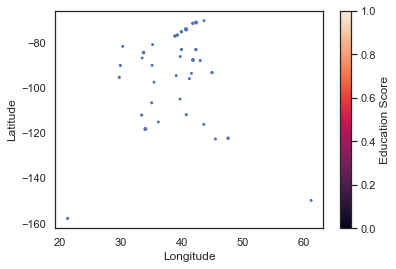

In [236]:
plt.scatter(lat,lon,education)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Education Score")


# Show plot
plt.savefig("educationscore.png")
plt.show()

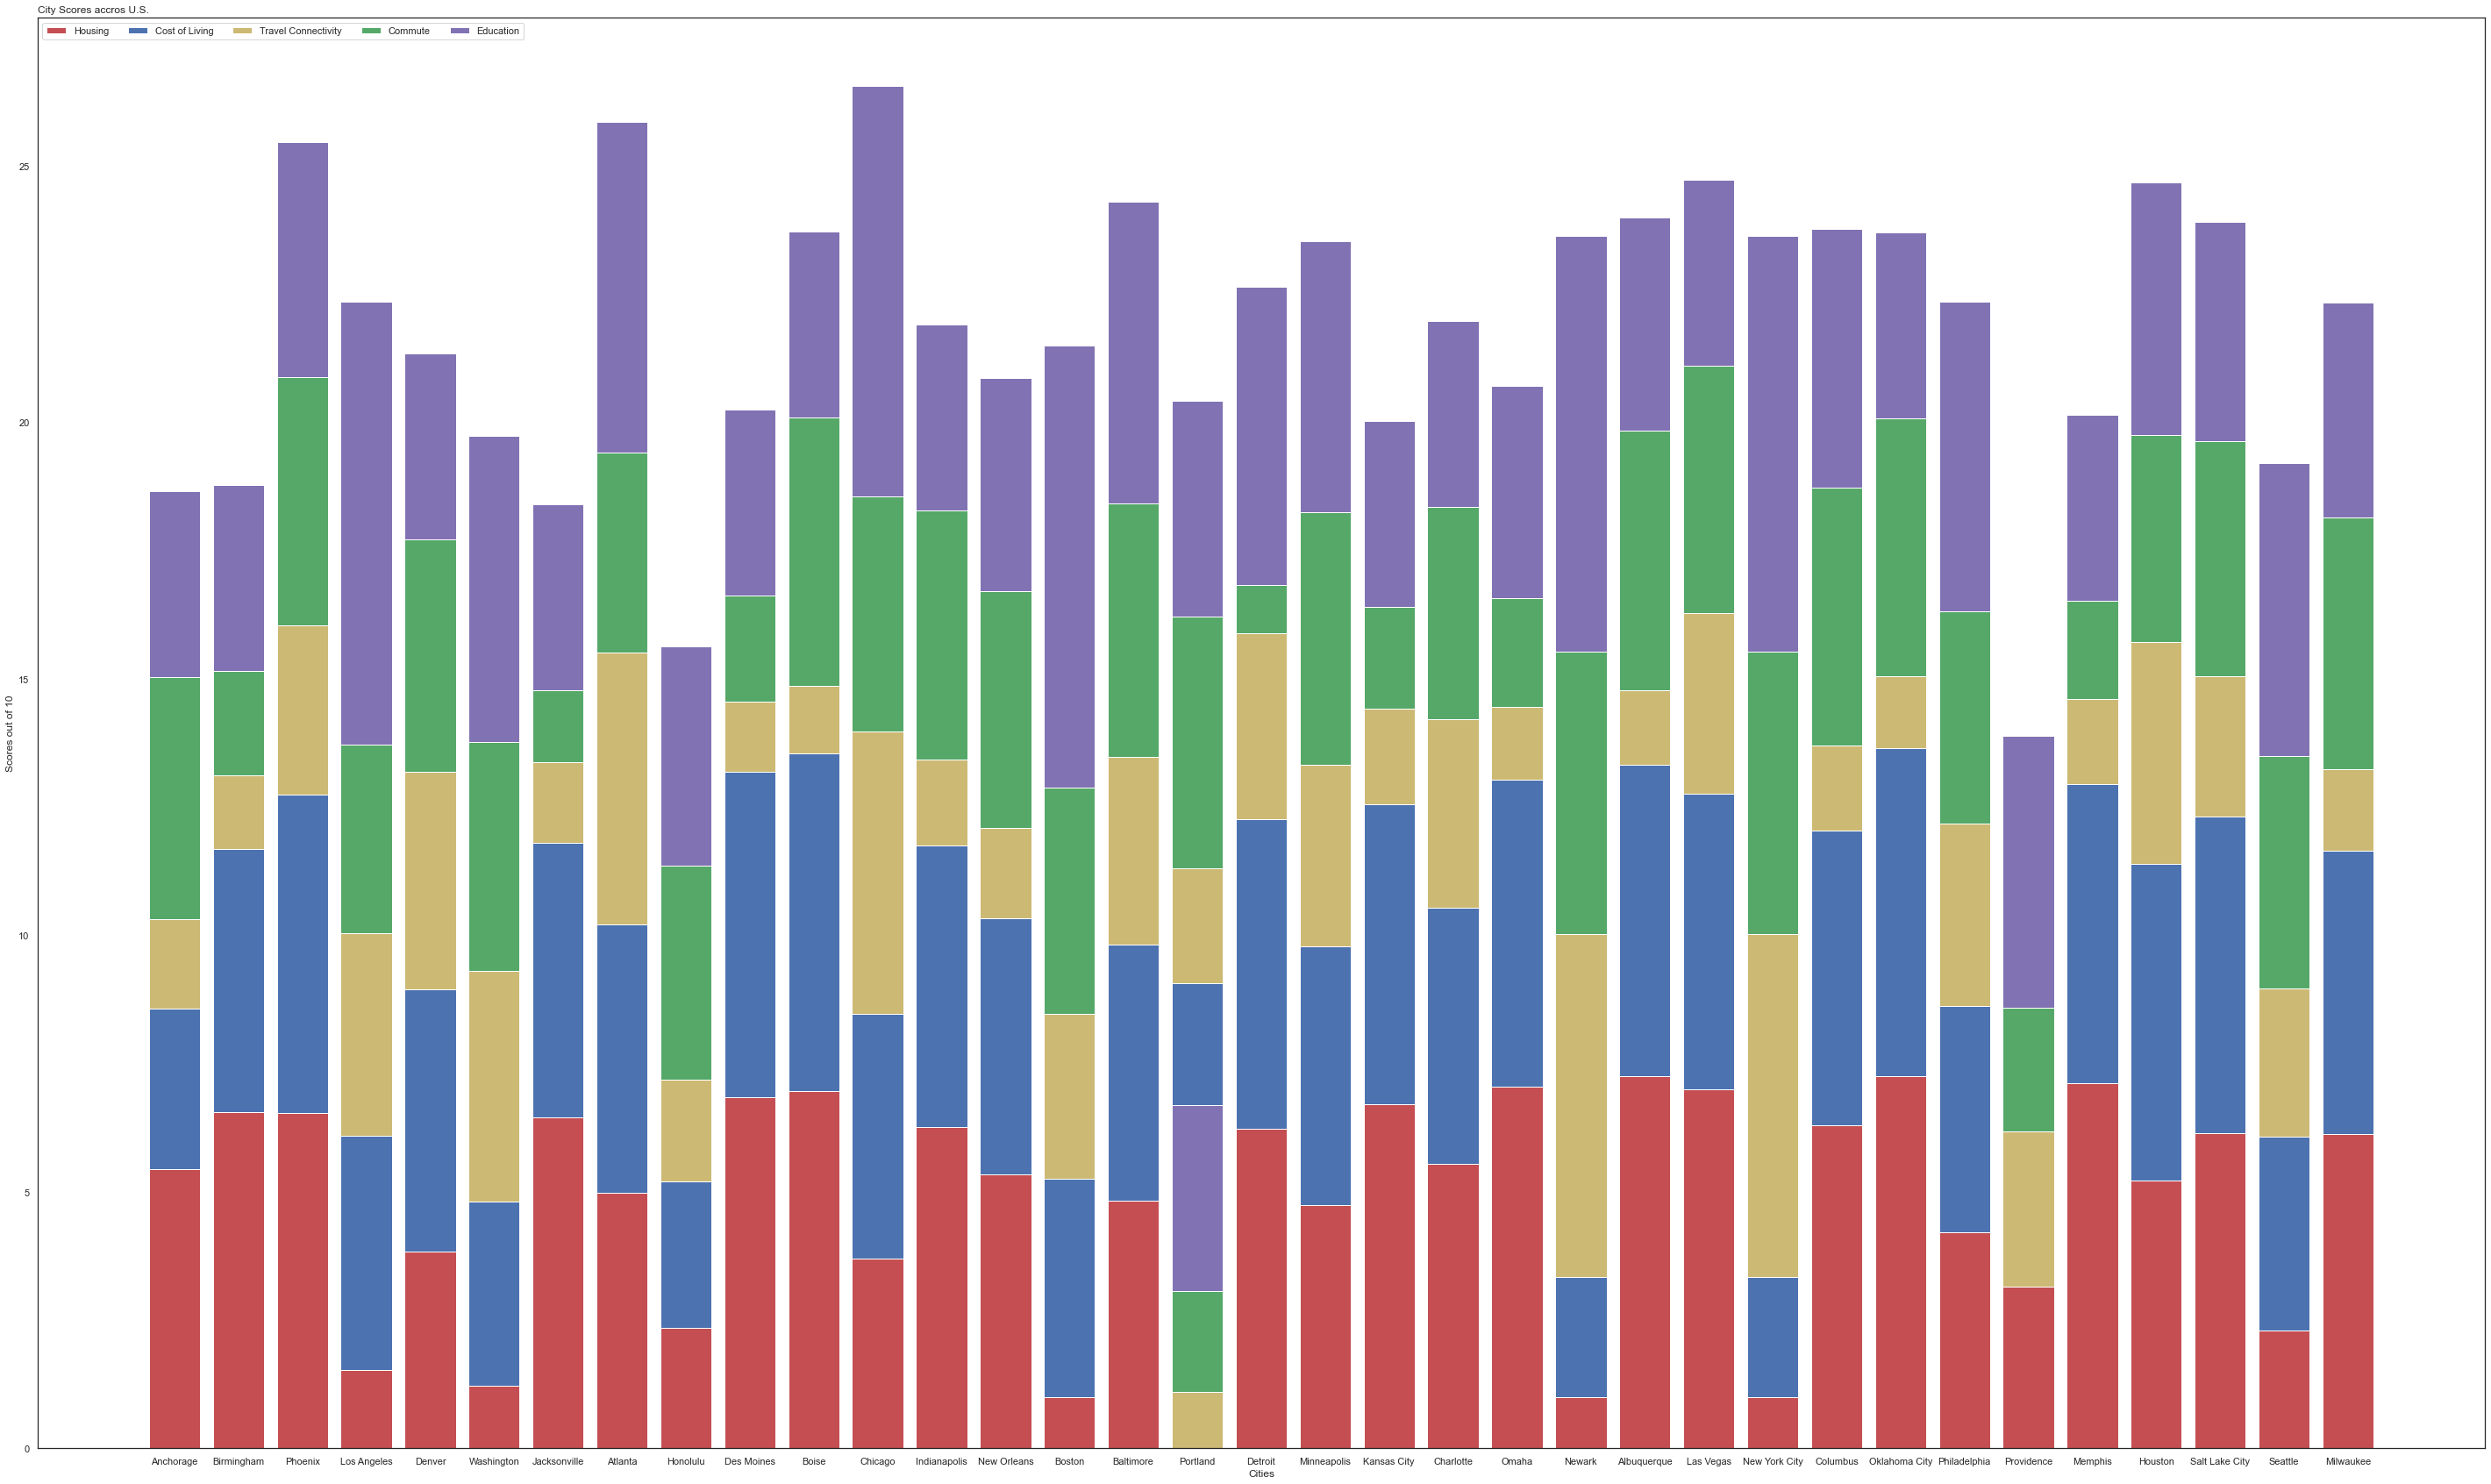

In [237]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, figsize=(50, 30))
# create data
x = cities
y1 = np.array(housing)
y2 = np.array(living)
y3 = np.array(travel)
y4 = np.array(commute)
y5 = np.array(education)
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='m')
plt.xlabel("Cities")
plt.ylabel("Scores out of 10")
plt.legend(["Housing", "Cost of Living", "Travel Connectivity", "Commute", "Education"],loc='upper left', ncol = 5)
plt.title("City Scores accros U.S.", loc ='left')
fig.align_labels()
plt.savefig("CityScores.png")
plt.show()


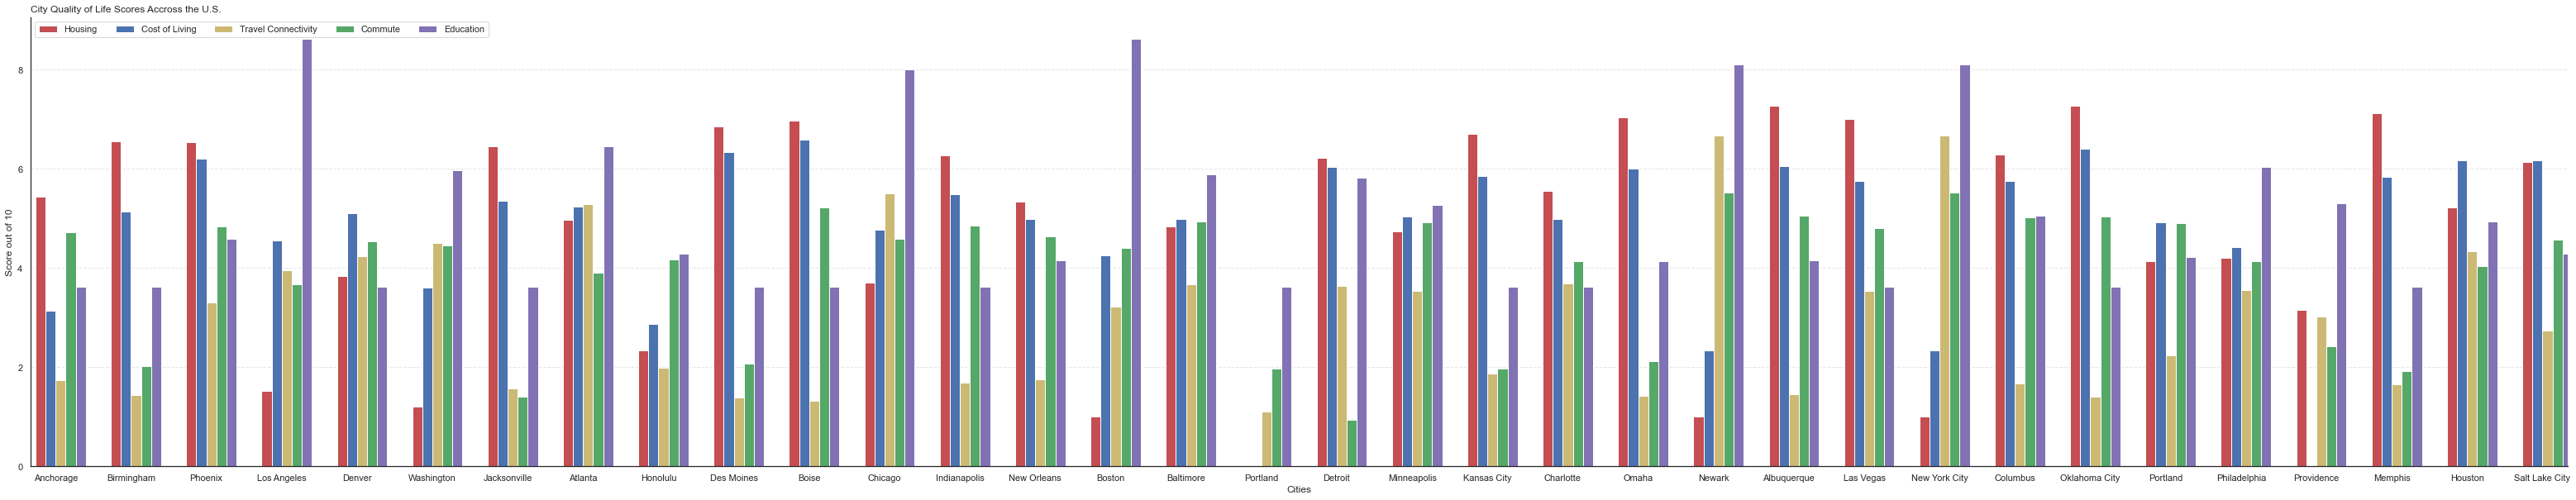

In [238]:
# define figure
fig, ax = plt.subplots(1, figsize=(55, 10))
# numerical x
x = np.arange(0, len(cities))*1.5
# plot bars
plt.bar(x - 0.3, housing, width = 0.2, color = 'r')
plt.bar(x - 0.1, living, width = 0.2, color = 'b')
plt.bar(x + 0.1, travel, width = 0.2, color = 'y')
plt.bar(x + 0.3, commute, width = 0.2, color = 'g')
plt.bar(x + 0.5, education, width = 0.2, color = 'm')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# x y details
plt.ylabel('Score out of 10')
plt.xlabel("Cities")
plt.xticks(x, cities)
plt.xlim(-0.5, 50)
# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)
# title and legend
plt.title('City Quality of Life Scores Accross the U.S.', loc ='left')
plt.legend(['Housing', 'Cost of Living', 'Travel Connectivity', 'Commute', 'Education'], loc='upper left', ncol = 5)
plt.savefig("CityScores2.png")
fig.align_labels()
plt.show()


In [239]:
sorted_top_housing = qol_df.sort_values(by = 'Housing', ascending = False, ignore_index=True)
top_5_housing=sorted_top_housing.head(5)
top_5_housing.to_csv("Top5inHousing.csv")
top_5_housing

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Albuquerque,NM,US,559121,35.08449,-106.65114,7.2620,6.059,1.4555,5.05575,4.1520
1,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245
2,Memphis,TN,US,655770,35.14953,-90.04898,7.1145,5.829,1.6615,1.91750,3.6245
3,Omaha,NE,US,443885,41.25626,-95.94043,7.0405,5.994,1.4165,2.12775,4.1280
4,Las Vegas,NV,US,623747,36.17497,-115.13722,7.0010,5.759,3.5285,4.80750,3.6245


In [240]:
sorted_bottom_housing = qol_df.sort_values(by = 'Housing', ascending = True, ignore_index=True)
bottom_5_housing=sorted_bottom_housing.head(5)
bottom_5_housing.to_csv("Bottom5inHousing.csv")
bottom_5_housing

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.102,1.97025,3.6245
1,Boston,MA,US,667137,42.35843,-71.05977,1.0000,4.259,3.215,4.39625,8.6245
2,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.675,5.51925,8.0935
3,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.675,5.51925,8.0935
4,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.505,4.45700,5.9685


In [241]:
sorted_top_living = qol_df.sort_values(by = 'Cost of Living', ascending = False, ignore_index=True)
top_5_living=sorted_top_living.head(5)
top_5_living.to_csv("Top5inCostofLiving.csv")
top_5_living

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245
1,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245
2,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910
4,Salt Lake City,UT,US,192672,40.76078,-111.89105,6.1410,6.172,2.7370,4.57400,4.2805


In [242]:
sorted_bottom_living = qol_df.sort_values(by = 'Cost of Living', ascending = True, ignore_index=True)
bottom_5_living=sorted_bottom_living.head(5)
bottom_5_living.to_csv("Bottom5inCostofLiving.csv")
bottom_5_living

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Providence,RI,US,179207,41.82399,-71.41283,3.1530,0.000,3.0185,2.42200,5.3015
1,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245
2,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935
3,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935
4,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805


In [243]:
sorted_top_travel = qol_df.sort_values(by = 'Travel Connectivity', ascending = False, ignore_index=True)
top_5_travel=sorted_top_travel.head(5)
top_5_travel.to_csv("Top5inTravel.csv")
top_5_travel

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935
1,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935
2,Chicago,IL,US,2720546,41.85003,-87.65005,3.7020,4.766,5.5075,4.57975,7.9990
3,Atlanta,GA,US,463878,33.749,-84.38798,4.9755,5.241,5.2915,3.89775,6.4570
4,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.5050,4.45700,5.9685


In [244]:
sorted_bottom_travel = qol_df.sort_values(by = 'Travel Connectivity', ascending = True, ignore_index=True)
bottom_5_travel=sorted_bottom_travel.head(5)
bottom_5_travel.to_csv("Bottom5inTravel.csv")
bottom_5_travel

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245
1,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245
2,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245
3,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245
4,Omaha,NE,US,443885,41.25626,-95.94043,7.0405,5.994,1.4165,2.12775,4.1280


In [245]:
sorted_top_commute = qol_df.sort_values(by = 'Commute', ascending = False, ignore_index=True)
top_5_commute=sorted_top_commute.head(5)
top_5_commute.to_csv("Top5inCommute.csv")
top_5_commute

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935
1,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935
2,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245
3,Albuquerque,NM,US,559121,35.08449,-106.65114,7.2620,6.059,1.4555,5.05575,4.1520
4,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245


In [246]:
sorted_bottom_commute = qol_df.sort_values(by = 'Commute', ascending = True, ignore_index=True)
bottom_5_commute=sorted_bottom_commute.head(5)
bottom_5_commute.to_csv("Bottom5inCommute.csv")
bottom_5_commute

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Detroit,MI,US,677116,42.33143,-83.04575,6.2230,6.032,3.6405,0.93300,5.8185
1,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245
2,Memphis,TN,US,655770,35.14953,-90.04898,7.1145,5.829,1.6615,1.91750,3.6245
3,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245
4,Kansas City,MO,US,475378,39.09973,-94.57857,6.7075,5.844,1.8690,1.97250,3.6245


In [247]:
sorted_top_education = qol_df.sort_values(by = 'Education', ascending = False, ignore_index=True)
top_5_education=sorted_top_education.head(5)
top_5_education.to_csv("Top5inEducation.csv")
top_5_education

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.67700,8.6245
1,Boston,MA,US,667137,42.35843,-71.05977,1.0000,4.259,3.2150,4.39625,8.6245
2,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935
3,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935
4,Chicago,IL,US,2720546,41.85003,-87.65005,3.7020,4.766,5.5075,4.57975,7.9990


In [248]:
sorted_bottom_education = qol_df.sort_values(by = 'Education', ascending = True, ignore_index=True)
bottom_5_education=sorted_bottom_education.head(5)
bottom_5_education.to_csv("Bottom5inEducation.csv")
bottom_5_education

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
2,Memphis,TN,US,655770,35.14953,-90.04898,7.1145,5.829,1.6615,1.91750,3.6245
3,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245
4,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.2430,4.53000,3.6245


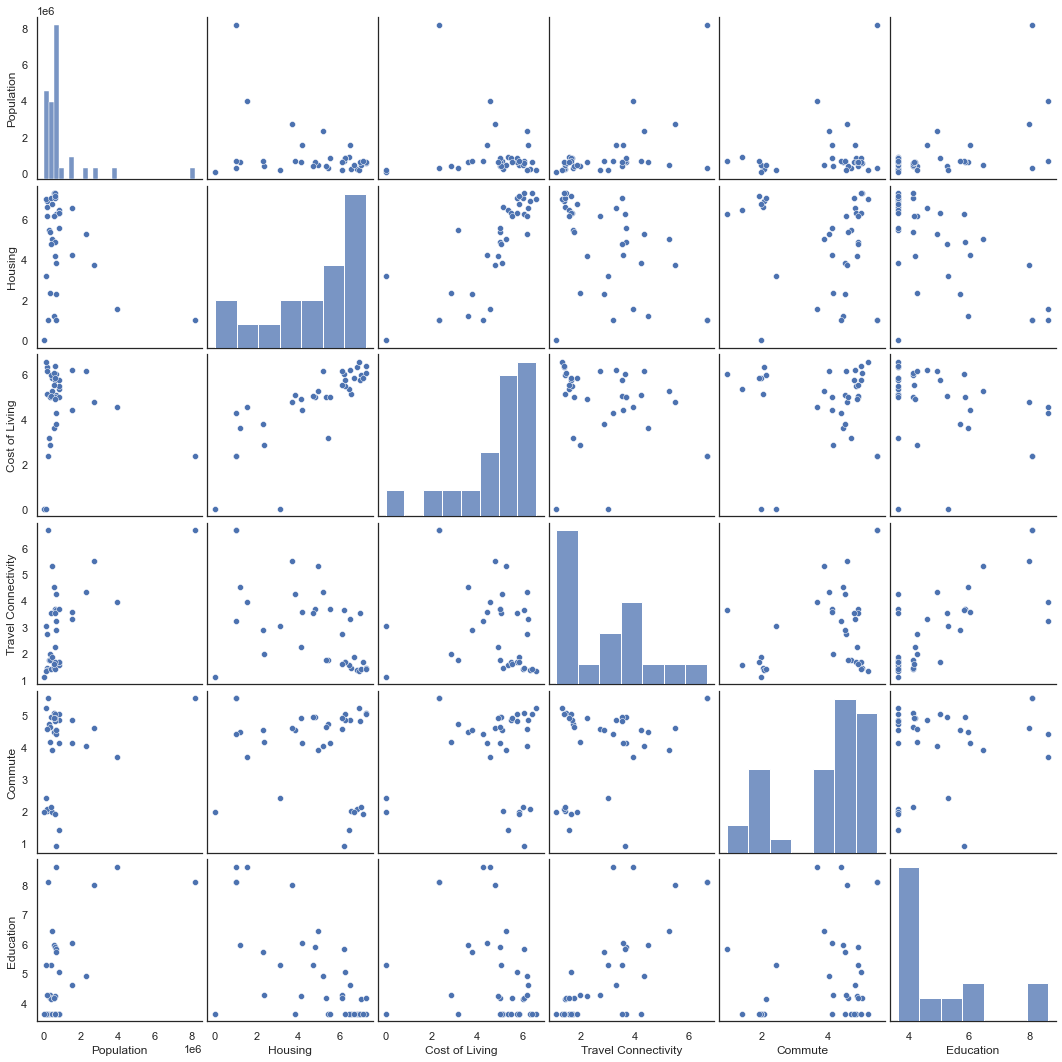

<Figure size 800x800 with 0 Axes>

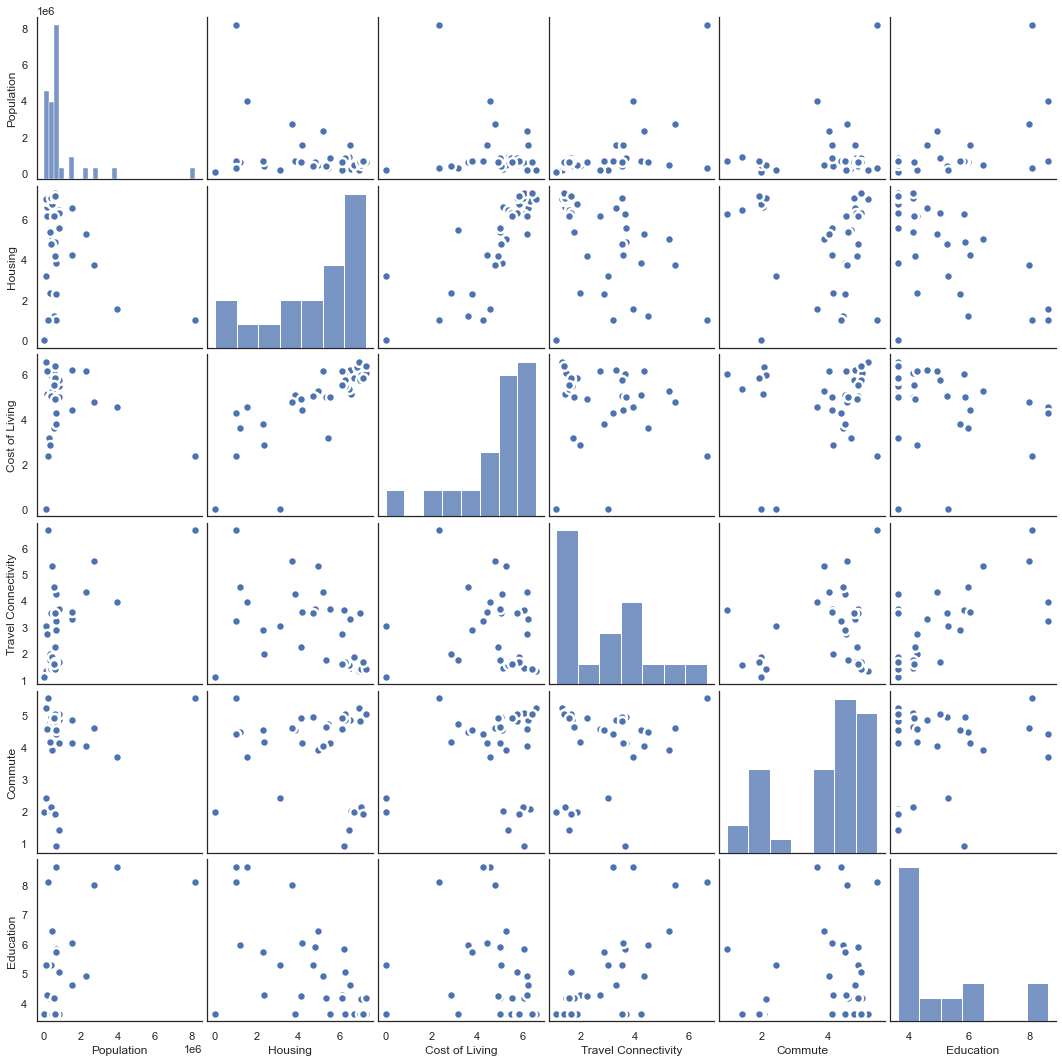

In [249]:
import seaborn as sns

sns.pairplot(qol_df)

# Plot
plt.figure(figsize=(10,10), dpi= 80)
sns.pairplot(qol_df, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.savefig("Pairplot.png")
plt.show()

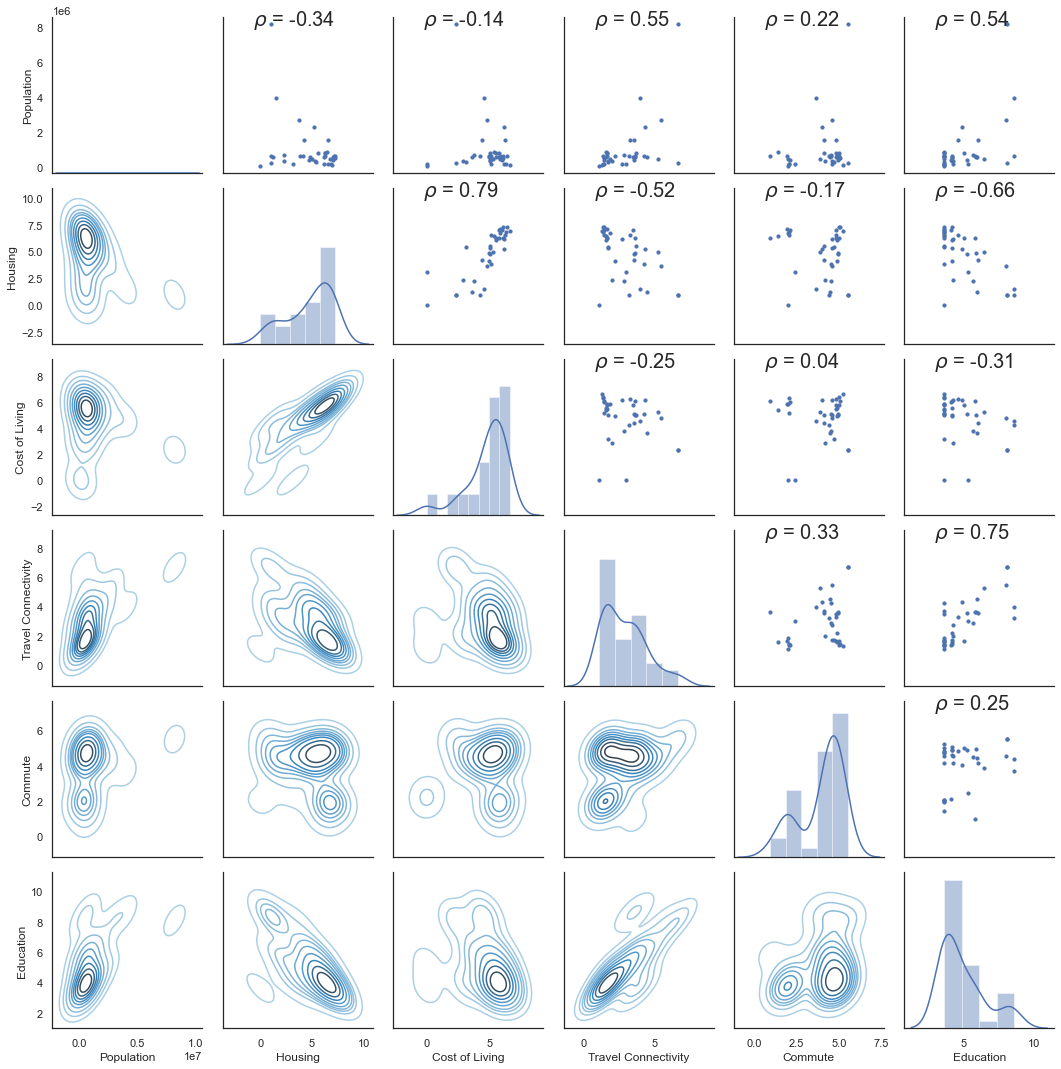

In [250]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    

# Map the plots to the locations
g = sns.PairGrid(qol_df, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_upper(corr)
g.map_diag(sns.distplot, kde=True)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
plt.savefig("PearsonRGrid.png")

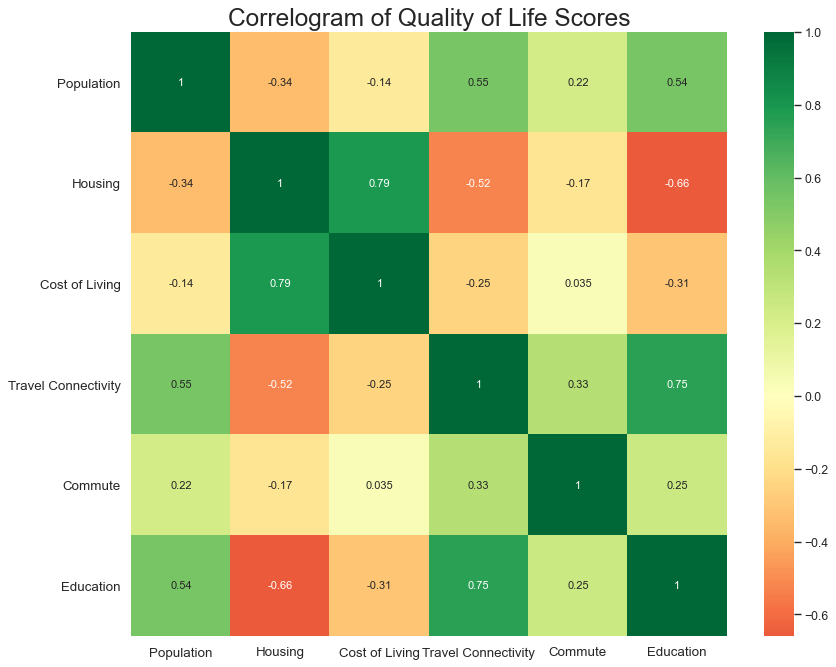

In [251]:
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(qol_df.corr(), xticklabels=qol_df.corr().columns, yticklabels=qol_df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of Quality of Life Scores', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("CorrelogramScores.png")
plt.show()